# Topic Analysis - pyLDAvis

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import spacy
import gensim
from gensim import corpora
from gensim.models import LdaModel
import pyLDAvis.gensim_models

In [2]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3" # Supress tensorflow warnings

## Data Preprocessing

### Importing the Dataset

In [3]:
current_dir = os.path.dirname(os.path.realpath('__file__'))
root = os.path.join(current_dir, "Books")

data = []

# Loop through author and book folders, adding .txt file contents to data with matching labels
for author in os.listdir(root):
    author_path = os.path.join(root, author)

    for book in os.listdir(author_path):
        book_path = os.path.join(author_path, book)

        for chapter in os.listdir(book_path):
            chapter_path = os.path.join(book_path, chapter)
            
            with open(chapter_path, 'r', encoding='utf-8') as file:
                text = file.read()
                
            data.append({
                'Author': author,
                'Book': book,
                'Chapter': chapter[:-4],
                'Text': text
            })

dataset = pd.DataFrame(data)

### Splitting and Cleaning

In [4]:
lemmatizer = WordNetLemmatizer()
nlp = spacy.load("en_core_web_sm")

def preserve_names(text):
    chapter = nlp(text)
    processed_text = []

    for word in chapter:
        # Checking if proper noun using nlp
        if word.pos_ == "PROPN":  
            processed_text.append(word.text)
        else:
            processed_text.append(word.text.lower())

    return processed_text

def preprocess_text(text, all_stopwords):
    if isinstance(text, str):
        # Clean text
        text = re.sub(r'\n', " ", text)  # Newlines
        text = re.sub(r'[^a-zA-Z\s]', " ", text)  # Punctuation and special characters
        text = re.sub(r'\s+', ' ', text).strip()  # Extra spaces
        words = preserve_names(text)
    else:
        words = text

    # Apply lemmatizer
    processed_text = [lemmatizer.lemmatize(word) for word in words if word not in all_stopwords]
    processed_text = " ".join(processed_text)
    
    return processed_text

In [5]:
nltk.download('wordnet', quiet = True)
nltk.download('stopwords', quiet = True)
all_stopwords = stopwords.words('english')
all_stopwords.remove('not')

# Apply our cleaning and create a new dataset to replace our previous one, this time with processed text
processed_text = []
for index, row in dataset.iterrows():
    text = row["Text"]
    processed_chapter = preprocess_text(text, all_stopwords)
    processed_text.append(processed_chapter)
    
# Convert the data fragments into a Pandas DataFrame and replace the original
dataset['Text'] = processed_text

In [6]:
dataset.head()

,Author,Book,Chapter,Text
0,Brandon Sanderson,The Way of Kings,1,killed Bastards killed sun still hot die colle...
1,Brandon Sanderson,The Way of Kings,10,nine year AGO Kal stumbled surgery room open d...
2,Brandon Sanderson,The Way of Kings,2,ten order loved forsaken u Almighty Shard soul...
3,Brandon Sanderson,The Way of Kings,3,man stood cliffside watched homeland fall dust...
4,Brandon Sanderson,The Way of Kings,4,dying Healer take blood beside head line see d...


## Creating and Training Model

In [7]:
import little_mallet_wrapper as lmw

training_data = [lmw.process_string(t) for t in dataset['Text'].tolist()]
training_data = [d for d in training_data if d.strip()]

# Check how many processed texts you have
len(training_data)

112

In [8]:
num_topics = 20

path_to_mallet = "./mallet-2.0.8/bin/mallet"

output_directory_path = "./LMW"
path_to_training_data           = output_directory_path + '/training.txt'
path_to_formatted_training_data = output_directory_path + '/mallet.training'
path_to_model                   = output_directory_path + '/mallet.model.' + str(num_topics)
path_to_topic_keys              = output_directory_path + '/mallet.topic_keys.' + str(num_topics)
path_to_topic_distributions     = output_directory_path + '/mallet.topic_distributions.' + str(num_topics)
path_to_word_weights            = output_directory_path + '/mallet.word_weights.' + str(num_topics)
path_to_diagnostics             = output_directory_path + '/mallet.diagnostics.' + str(num_topics) + '.xml'

alpha_value = 0.1

lmw.import_data(path_to_mallet,
                path_to_training_data,
                path_to_formatted_training_data,
                training_data)

Importing data...
Complete


In [9]:
lmw.train_topic_model(path_to_mallet,
                      path_to_formatted_training_data,
                      path_to_model,
                      path_to_topic_keys,
                      path_to_topic_distributions,
                      path_to_word_weights,
                      path_to_diagnostics,
                      num_topics)

Training topic model...


Mallet LDA: 20 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 7831
total tokens: 235262
<10> LL/token: -9.77415
<20> LL/token: -9.38657
<30> LL/token: -9.23446
<40> LL/token: -9.13991

0	0.25	kaladin man stone one back men hand side soldier away others around foot cenn blood spear across shoulder wall holding 
1	0.25	said see got say well time get went old good want water along took money jim mrs take let come 
2	0.25	life yet upon dear day one love mother eye hand made feel seemed mind every work answered shall child nature 
3	0.25	buck sea father god first towards brother already even also still upon thus nastasya jonah clerk heard letter water without 
4	0.25	gatsby tom daisy house little came room car light went new girl never clock hand miss wilson eye jordan want 
5	0.25	said stephen know word think girl john letter asked wife life best call world came son mean dounia lord boy 
6	0.25	one even could light eye would see king slave sedai two min aes still dragon to

Complete


In [10]:
topic_keys = lmw.load_topic_keys(output_directory_path + '/mallet.topic_keys.' + str(num_topics))

for i, t in enumerate(topic_keys):
    print(i, '\t', ' '.join(t[:10]))

0 	 kaladin szeth bridge slave cenn soldier man tvlakv wagon dallet
1 	 got would say went jim could old warn see well
2 	 upon would could life may mind even great shall house
3 	 elizabeth justine thus also hope poor fear clerval dear whose
4 	 gatsby daisy tom car wilson jordan house went room sport
5 	 stephen said mulligan buck haines sir john hamlet deasy eglinton
6 	 rand sedai woman min aes even dragon would tower could
7 	 sea jonah ship god upon bed harpooneer whale landlord yet
8 	 bloom like yes must water fellow wonder chap flynn year
9 	 lorry prisoner business gentleman sir upon defarge jerry passenger wine
10 	 perrin wolf hopper said faile dream slayer sent young bull
11 	 said one man time like know see come two well
12 	 shallan jasnah said father brightness yalb woman kal servant sphere
13 	 said professor see molloy bloom myles lenehan crawford editor dublin
14 	 back hand one could would eye side men like light
15 	 raskolnikov though room dounia went suddenly wou

In [11]:
topic_distributions = lmw.load_topic_distributions(output_directory_path + '/mallet.topic_distributions.' + str(num_topics))

len(topic_distributions), len(topic_distributions[0])

(112, 20)

In [12]:
topic_word_probability_dict = lmw.load_topic_word_distributions(output_directory_path + '/mallet.word_weights.' + str(num_topics))

len(topic_word_probability_dict)

20

In [13]:
for _topic, _word_probability_dict in topic_word_probability_dict.items():
    print('Topic', _topic)
    for _word, _probability in sorted(_word_probability_dict.items(), key=lambda x: x[1], reverse=True)[:5]:
        print(round(_probability, 4), '\t', _word)
    print()

Topic 0
0.0558 	 kaladin
0.0177 	 szeth
0.0165 	 bridge
0.0138 	 slave
0.0126 	 cenn

Topic 1
0.0219 	 got
0.0125 	 would
0.0123 	 say
0.0121 	 went
0.0104 	 jim

Topic 2
0.0147 	 upon
0.0127 	 would
0.0096 	 could
0.0094 	 life
0.0084 	 may

Topic 3
0.0073 	 elizabeth
0.0069 	 justine
0.0059 	 thus
0.0053 	 also
0.0048 	 hope

Topic 4
0.0319 	 gatsby
0.0227 	 daisy
0.0209 	 tom
0.0096 	 car
0.0082 	 wilson

Topic 5
0.0376 	 stephen
0.0297 	 said
0.0215 	 mulligan
0.0179 	 buck
0.01 	 haines

Topic 6
0.0189 	 rand
0.0131 	 woman
0.0131 	 sedai
0.0127 	 min
0.0125 	 aes

Topic 7
0.0169 	 sea
0.0121 	 jonah
0.0101 	 ship
0.0095 	 god
0.0093 	 upon

Topic 8
0.0151 	 bloom
0.0088 	 like
0.0054 	 water
0.0054 	 must
0.0054 	 yes

Topic 9
0.0172 	 lorry
0.0139 	 prisoner
0.013 	 business
0.0119 	 gentleman
0.0113 	 sir

Topic 10
0.0746 	 perrin
0.0263 	 wolf
0.0244 	 hopper
0.0188 	 said
0.0109 	 faile

Topic 11
0.0246 	 said
0.0176 	 one
0.0142 	 man
0.0136 	 time
0.0126 	 like

Topic 12
0.

In [14]:
gensim_text = dataset["Text"]
gensim_text = [chapter.split() for chapter in gensim_text]

from gensim.corpora import Dictionary
id2word = Dictionary(gensim_text)

In [15]:
from gensim.models.coherencemodel import CoherenceModel

# Compute coherence score
coherence_model = CoherenceModel(topics=topic_keys, 
                                 texts=gensim_text, 
                                 dictionary=id2word,  # Ensure this is your Gensim dictionary
                                 coherence='c_v')

coherence_score = coherence_model.get_coherence()
print(f'Coherence Score: {coherence_score}')


Coherence Score: 0.38008483700760676


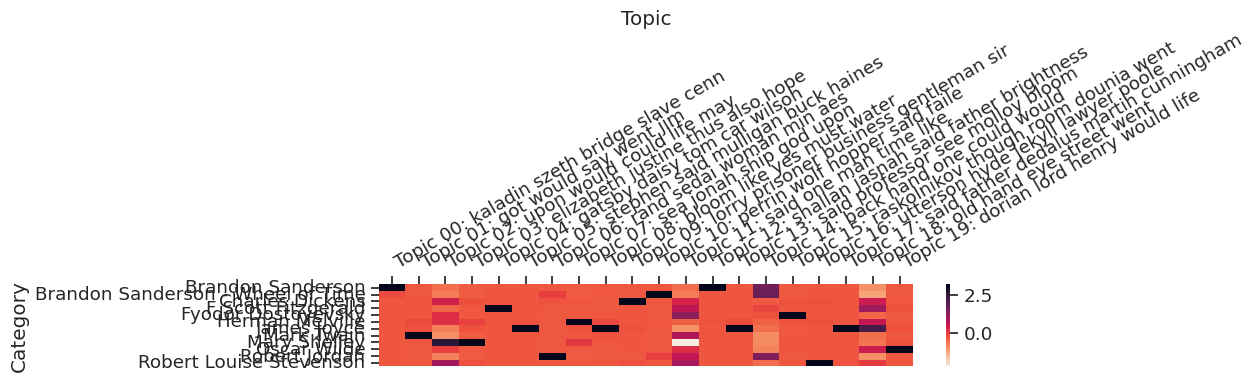

In [16]:
authors = dataset["Author"].tolist()
target_labels = dataset["Author"].unique().tolist()

lmw.plot_categories_by_topics_heatmap(authors,
                                      topic_distributions,
                                      topic_keys, 
                                      output_directory_path + '/categories_by_topics.pdf',
                                      target_labels=target_labels,
                                      dim=(12,4))

In [17]:
def convertldaGenToldaMallet(mallet_model):
    model_gensim = LdaModel(
        id2word=id2word, num_topics=20,
        alpha=mallet_model.alpha, eta=0,
    )
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

optimal_model = convertldaGenToldaMallet(optimal_model)

NameError: name 'optimal_model' is not defined

In [18]:
pyLDAvis.enable_notebook()

# Assuming you have your `lda_model`, `corpus`, and `dictionary`
vis = pyLDAvis.gensim_models.prepare(lmw, gensim_text, id2word)
pyLDAvis.display(vis)

ValueError: not enough values to unpack (expected 2, got 1)